In [1]:
import htucker as ht
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
import random
from tqdm import tqdm
import os

In [2]:
data_dir = Path("data/batch_3")
normalized_dir = Path(data_dir / "normalized")
normalized_data_dir = Path(normalized_dir / "data")
file_list = [*normalized_data_dir.iterdir()]

In [3]:
compressor = ht.HTucker.load("compressed_train_10.hto", str(data_dir))

In [4]:
def compress(compressor, tensor):
    tensor = tensor.transpose(1,0).reshape(128, 17)
    return compressor.project(tensor)

In [5]:
def decompress(compressor, tensor):
    decompressed = compressor.reconstruct(tensor).reshape(128, 17).transpose(1,0)
    return decompressed

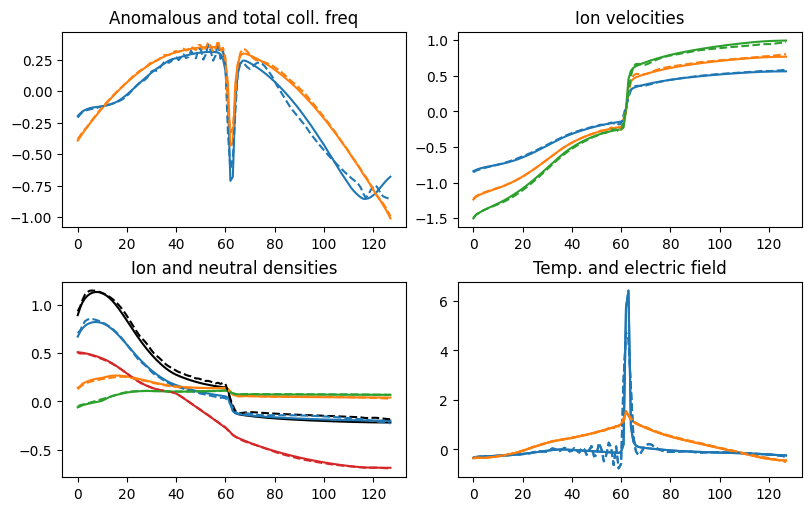

In [6]:
#tensor = np.load(file_list[41])["data"]
tensor = np.load(random.choice(file_list))["data"]
compressed = compress(compressor, tensor)
decompressed = decompress(compressor, compressed)

fig, ax = plt.subplots(2,2, figsize = (8,5), layout = 'constrained')
ax = ax.ravel()
ax[0].set(title = "Anomalous and total coll. freq")
ax[0].plot(tensor[1], color = "tab:blue")
ax[0].plot(tensor[2], color = "tab:orange")
ax[0].plot(decompressed[1], color = "tab:blue", linestyle = "--")
ax[0].plot(decompressed[2], color = "tab:orange", linestyle = "--")

ax[1].set(title = "Ion velocities")
ax[1].plot(tensor[8])
ax[1].plot(tensor[9] * np.sqrt(2)) 
ax[1].plot(tensor[10] * np.sqrt(3))
ax[1].plot(decompressed[8], color = "tab:blue", linestyle = "--")
ax[1].plot(decompressed[9] * np.sqrt(2), color = "tab:orange", linestyle = "--")
ax[1].plot(decompressed[10] * np.sqrt(3), color = "tab:green", linestyle = "--")

ax[2].set(title = "Ion and neutral densities")
ax[2].plot(tensor[3], color = "tab:red")
ax[2].plot(tensor[4] * 1.5, color = "black")
ax[2].plot(tensor[5] / 1, color = "tab:blue")
ax[2].plot(tensor[6] / 2, color = "tab:orange")
ax[2].plot(tensor[7] / 3, color = "tab:green")
ax[2].plot(decompressed[3], color = "tab:red", linestyle = "--")
ax[2].plot(decompressed[4] * 1.5, color = "black", linestyle = "--")
ax[2].plot(decompressed[5] / 1, color = "tab:blue", linestyle = "--")
ax[2].plot(decompressed[6] / 2, color = "tab:orange", linestyle = "--")
ax[2].plot(decompressed[7] / 3, color = "tab:green", linestyle = "--")

ax[3].set(title = "Temp. and electric field")
ax[3].plot(tensor[13], color = "tab:blue")
ax[3].plot(tensor[14], color = "tab:orange")
ax[3].plot(decompressed[13], color = "tab:blue", linestyle = "--")
ax[3].plot(decompressed[14], color = "tab:orange", linestyle = "--")

ax[3].set(title = "Temp. and electric field")
ax[3].plot(tensor[13], color = "tab:blue")
ax[3].plot(tensor[14], color = "tab:orange")
ax[3].plot(decompressed[13], color = "tab:blue", linestyle = "--")
ax[3].plot(decompressed[14], color = "tab:orange", linestyle = "--")

In [7]:
def load_and_compress(dataset_dir, compressor, num):
    core = compressor.root.core
    batch_dim = compressor.batch_dimension
    idx = [slice(None)] * core.ndim
    idx[batch_dim] = 1
    core_slice = core[tuple(idx)]
    dimension = np.prod(core_slice.shape)

    directory= Path(dataset_dir)
    files = os.listdir(directory)

    indices = np.random.choice(np.arange(len(files)), size=num)

    reshape = (dimension, num)
    samples = np.array([np.load(directory/files[i])["data"] for i in indices])
    samples = samples.transpose(2, 1, 0)
    compressed = compressor.project(samples, batch=True, batch_dimension=2).reshape(reshape)

    return compressed

In [8]:
def compute_gaussian_stats(directory: str | Path, compressor, num: int | None = None):
    compressed = load_and_compress(directory, compressor, num)
    mean = np.mean(compressed, axis=1)
    cov = np.cov(compressed)
    return mean, cov

In [9]:
mean_train, cov_train = compute_gaussian_stats(normalized_data_dir, compressor, 2**15)
np.savez(data_dir / "latent_stats_train.npz", mean = mean_train, cov = cov_train)

In [10]:
def load_mean_cov(file):
    data = np.load(file)
    return data["mean"], data["cov"]

In [11]:
def w2_distance(mean1, mean2, cov1, cov2):
    # Shape checking
    d = mean1.size
    assert mean1.shape == (d,)
    assert mean2.shape == (d,)
    assert cov1.shape == (d,d)
    assert cov2.shape == (d,d)

    nugget = 1e-8 * np.eye(d)
    sqrt_prod = scipy.linalg.sqrtm(cov1 @ cov2 + nugget)
    
    return np.linalg.norm(mean1 - mean2)**2 + np.trace(cov1 + cov2 - 2 * sqrt_prod)

In [85]:
num_samples = [10, 12, 14]
num_trials = 100

dist_means = np.zeros((len(num_samples), num_trials))
for (i, n) in enumerate(num_samples):
    print(f"{n=}")
    for trial in tqdm(range(num_trials)):
        mean_test, cov_test = compute_gaussian_stats(data_dir / "normalized_test_large" / "data", compressor, num = 2**n)
        dist_mean = w2_distance(mean_test, mean_train, cov_test, cov_train)
        dist_means[i, trial] = dist_mean


n=10


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


n=12


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


n=14


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


FID_inf = 0.89 (95% CI 0.32-5.60)


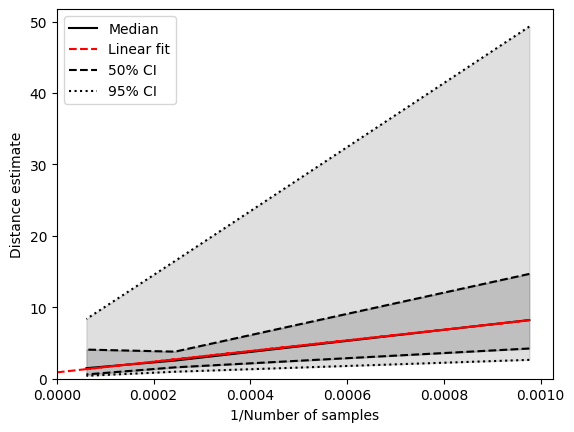

In [86]:
FID_means = np.mean(dist_means, axis=1)
FID_vars = np.var(dist_means, axis=1)
FID_min, FID_lo, FID_med, FID_hi, FID_max = np.quantile(dist_means, [0.025, 0.25, 0.5, 0.75, 0.975], axis=1)

fig, ax = plt.subplots(1,1)
#ax.set(xlabel = "Number of samples", ylabel = "Distance estimate")
ax.set(xlabel = "1/Number of samples", ylabel = "Distance estimate")

#ax.set_xscale("log", base=2)
#ax.set_yscale("log")

N = 2**(np.array(num_samples))
linefit_med = np.polyfit(1/N, FID_med, 1)
linefit_min = np.polyfit(1/N, FID_min, 1)
linefit_max = np.polyfit(1/N, FID_max, 1)

extrapolation_x = np.hstack(([0], 1/N))
extrapolation_med = linefit_med[0] * extrapolation_x + linefit_med[1]
extrapolation_min = linefit_min[0] * extrapolation_x + linefit_min[1]
extrapolation_max = linefit_max[0] * extrapolation_x + linefit_max[1]

#ax.plot(1/N, FID_means, color = 'blue', label = 'Mean')
ax.plot(1/N, FID_med, color = 'black', label = "Median")
ax.plot(extrapolation_x, extrapolation_med, color = 'red', label = 'Linear fit', linestyle = '--')

FID_inf = extrapolation_med[0]
FID_inf_min = extrapolation_min[0]
FID_inf_max = extrapolation_max[0]

print(f"FID_inf = {FID_inf:.2f} (95% CI {FID_inf_min:.2f}-{FID_inf_max:.2f})")

ax.plot(1/N, FID_lo, color = 'black', linestyle = 'dashed', label = '50% CI')
ax.plot(1/N, FID_hi, color = 'black', linestyle = 'dashed')
ax.plot(1/N, FID_min, color = 'black', linestyle = ':', label = '95% CI')
ax.plot(1/N, FID_max, color = 'black', linestyle = ':')
ax.fill_between(1/N, FID_lo, FID_hi, color = 'gray', alpha = 0.5)
ax.fill_between(1/N, FID_min, FID_lo, color = 'gray', alpha = 0.25)
ax.fill_between(1/N, FID_hi, FID_max, color = 'gray', alpha = 0.25)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.legend()
plt.show()

In [ ]:
train_dir = data_dir / "normalized" / "data"
test_dir = data_dir / "normalized_test_large" / "data"

In [32]:
from numba import njit

@njit
def gaussian_rbf_kernel(r2, sigma = 10.0):
    return np.exp(-r2 / (2 * sigma**2))

def kernel_sum(X, Y, sigma = 10.0, zero_diag=False):

    nx, mx = X.shape
    ny, my = Y.shape

    r2 = scipy.spatial.distance.cdist(X, Y, 'sqeuclidean')

    assert r2.shape == (nx, ny) 

    k = gaussian_rbf_kernel(r2, sigma=sigma)
    if zero_diag:
        np.fill_diagonal(k, 0.0)

    return np.sum(k)

def calc_mmd(X, Y, bandwidth = 10.0):
    (m, _) = X.shape
    (n, _) = Y.shape

    k_xx = kernel_sum(X, X, bandwidth, zero_diag=True) / (m * (m-1))
    k_yy = kernel_sum(Y, Y, bandwidth, zero_diag=True) / (n * (n-1))
    k_xy = kernel_sum(X, Y, bandwidth, zero_diag=False) / (m * n)

    return k_xx + k_yy - 2 * k_xy

In [63]:
ps = np.arange(5, 12)
noise_level = [0, 1, 10]
trials = 20
mmds = np.zeros((len(noise_level), len(ps), trials))

for (j, std) in enumerate(noise_level): 
    for (i, p) in enumerate(ps):
        N = 2**p
        X = load_and_compress(train_dir, compressor, N).T
        for trial in range(trials):
            Y = load_and_compress(test_dir, compressor, N).T
            Y_noised = Y + np.random.randn(X.size).reshape(X.shape) * std
            mmds[j, i, trial] = calc_mmd(X, Y_noised, bandwidth=20)


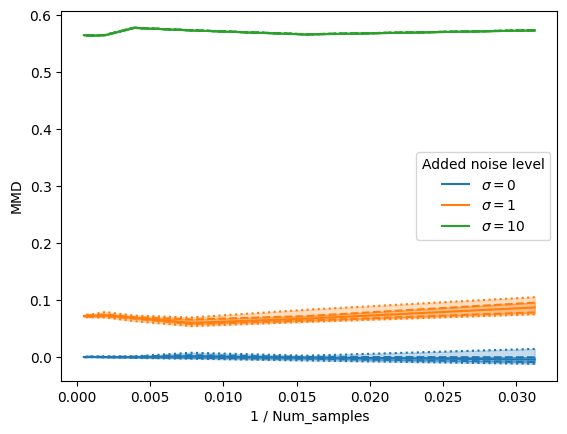

In [64]:
inv_N = 1 / (2**ps)

fig, ax = plt.subplots(1,1)

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
]

for (i, std) in enumerate(noise_level):

    mmd_mat = mmds[i, : :]

    mmd_lo, mmd_25, mmd_med, mmd_75, mmd_hi = np.quantile(mmd_mat, [0.025, 0.25, 0.5, 0.75, 0.975], axis=1)

    ax.plot(inv_N, mmd_lo, label = "", linestyle = ':', color = colors[i])
    ax.plot(inv_N, mmd_hi, label = "", linestyle = ':', color = colors[i])
    ax.plot(inv_N, mmd_25, label = "", linestyle = '--', color = colors[i])
    ax.plot(inv_N, mmd_75, label = "", linestyle = '--', color = colors[i])
    ax.fill_between(inv_N, mmd_25, mmd_75, color = colors[i], alpha = 0.5)
    ax.fill_between(inv_N, mmd_lo, mmd_25, color = colors[i], alpha = 0.25)
    ax.fill_between(inv_N, mmd_75, mmd_hi, color = colors[i], alpha = 0.25)
    ax.plot(inv_N, mmd_med, label = f"$\\sigma = {std}$", color = colors[i])

ax.legend(title = "Added noise level")
ax.set(xlabel = "1 / Num_samples", ylabel = "MMD")
plt.show()